# Pathway and full outcome models

In [1]:
# import required modules
import numpy as np
import pandas as pd
from math import sqrt
from scipy import stats
import copy

from classes.pathway import SSNAP_Pathway
from classes.clinical_outcome import Clinical_outcome

## Import data for clinical outcome

Probability distributions of modified Rankin scale (mRS):

In [2]:
mrs_dists = pd.read_csv('data/mrs_dist_probs_cumsum.csv', index_col='Stroke type')

In [3]:
mrs_dists

,0,1,2,3,4,5,6
Stroke type,,,,,,,
pre_stroke_nlvo,0.582881,0.745419,0.848859,0.951082,0.993055,1.000000,1.0
pre_stroke_nlvo_ivt_deaths,0.576469,0.737219,0.839522,0.940620,0.982131,0.989000,1.0
pre_stroke_lvo,0.417894,0.560853,0.679283,0.843494,0.957269,1.000000,1.0
pre_stroke_lvo_ivt_deaths,0.403644,0.541728,0.656119,0.814731,0.924626,0.965900,1.0
pre_stroke_lvo_mt_deaths,0.402850,0.540662,0.654829,0.813128,0.922807,0.964000,1.0
no_treatment_nlvo,0.197144,0.460000,0.580032,0.707768,0.855677,0.917702,1.0
no_effect_nlvo_ivt_deaths,0.197271,0.460000,0.577583,0.702252,0.845244,0.904454,1.0
t0_treatment_nlvo_ivt,0.429808,0.630000,0.738212,0.848427,0.929188,0.956300,1.0
no_treatment_lvo,0.050000,0.129000,0.265000,0.429000,0.676000,0.811000,1.0


## Minimal example: clinical outcome model

The model needs the following data as inputs, with one value per patient in each array:

| Data | Units | Data type | Name |
| --- | --- | --- | --- |
| Stroke type code | 0=other, 1=nLVO, 2=LVO | int | `stroke_type_code` |
| Onset to needle time | minutes | float | `onset_to_needle_mins` |
| Whether IVT was chosen | 1=True, 0=False | int or bool | `ivt_chosen_bool` |
| Onset to puncture time | minutes | float | `onset_to_puncture_mins` |
| Whether MT was chosen | 1=True, 0=False | int or bool | `mt_chosen_bool` |

These are expected in a dictionary (or a pandas DataFrame? check this). For example:

In [4]:
time_to_ivt_mins = 90.0
time_to_mt_mins = 120.0

n_nlvo = 65
n_lvo = 35
n_total = n_lvo + n_nlvo

outcome_inputs_dict = dict(
    # Mix of LVO and nLVO:
    stroke_type_code = np.array([2]*n_lvo + [1]*n_nlvo),
    # Onset to needle time is fixed to 90mins:
    onset_to_needle_mins = np.full(n_total, time_to_ivt_mins),
    # Randomly pick whether IVT is chosen with around 15% yes: 
    ivt_chosen_bool = np.random.binomial(1, 0.15, n_total) == 1,
    # Onset to puncture time is fixed to 120mins:
    onset_to_puncture_mins = np.full(n_total, time_to_mt_mins),
    # Randomly pick whether MT is chosen for LVOs with around 30% yes:
    mt_chosen_bool = np.concatenate(
        (np.random.binomial(1, 0.3, n_lvo), [0]*n_nlvo)) == 1
)

Convert this to a DataFrame for easier viewing:

In [5]:
# Pop them into a dataframe:
outcome_inputs_df = pd.DataFrame(
    np.array(list(outcome_inputs_dict.values()), dtype=object).T,
    columns=outcome_inputs_dict.keys(),
)

# Show the first ten patients' details:
outcome_inputs_df.head(10).T

,0,1,2,3,4,5,6,7,8,9
stroke_type_code,2,2,2,2,2,2,2,2,2,2
onset_to_needle_mins,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0
ivt_chosen_bool,False,False,False,False,False,False,True,False,True,False
onset_to_puncture_mins,120.0,120.0,120.0,120.0,120.0,120.0,120.0,120.0,120.0,120.0
mt_chosen_bool,False,True,True,False,False,True,False,False,True,True


### Run the clinical outcome model using this data.

In [6]:
# Initiate the outcome model object:
clinical_outcome = Clinical_outcome(mrs_dists, n_total)
# Import patient array data:
for key in clinical_outcome.trial.keys():
    if key in outcome_inputs_df:
        clinical_outcome.trial[key].data = outcome_inputs_dict[key]

# Calculate outcomes:
results_by_stroke_type, patient_array_outcomes = clinical_outcome.calculate_outcomes()

# Make a copy:
results_by_stroke_type = copy.copy(results_by_stroke_type)
patient_array_outcomes = copy.copy(patient_array_outcomes)

`results_by_stroke_type` is a dictionary. For each of `lvo_ivt`, `lvo_mt`, `nlvo_ivt`, this contains the following keys:

+ '_each_patient_post_stroke_mrs_dist'
+ '_untreated_mean_mrs'
+ '_no_effect_mean_mrs' 
+ '_each_patient_post_stroke_mean_mrs'
+ '_each_patient_mean_mrs_shift'
+ '_untreated_mean_utility'
+ '_no_effect_mean_utility'
+ '_each_patient_post_stroke_mean_utility'
+ '_each_patient_mean_added_utility'
+ '_mean_valid_patients_mean_mrs_shift' 
+ '_mean_valid_patients_mean_added_utility' 
+ '_treated_population_mean_valid_patients_mean_mrs_shift'
+ '_treated_population_mean_valid_patients_mean_added_utility'

`patient_array_outcomes` combines the three subgroups back into one big array in the same order as the input data. It contains:

+ 'each_patient_post_stroke_mrs_dist'
+ 'each_patient_post_stroke_mean_mrs'
+ 'each_patient_mean_mrs_shift'
+ 'each_patient_post_stroke_mean_utility'
+ 'each_patient_mean_added_utility'
+ 'post_stroke_mean_mrs'
+ 'mean_mrs_shift'
+ 'mean_utility'
+ 'mean_added_utility'

In [7]:
# Separate subgroup results:
keys_to_print = [
    'nlvo_ivt_treated_population_mean_valid_patients_mean_mrs_shift',
    'lvo_ivt_treated_population_mean_valid_patients_mean_mrs_shift',
    'lvo_mt_treated_population_mean_valid_patients_mean_mrs_shift',
]
for key in keys_to_print:
    print(f'{results_by_stroke_type[key]:.3f}')

-0.623
-0.178
-1.006


In [8]:
# Combined full cohort results:
patient_array_outcomes['each_patient_mean_mrs_shift']

array([ 0.        , -1.0059692 , -1.0059692 ,  0.        ,  0.        ,
       -1.0059692 , -0.17769684,  0.        , -1.0059692 , -1.0059692 ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
       -1.0059692 ,  0.        ,  0.        , -1.0059692 , -0.17769684,
        0.        ,  0.        , -1.0059692 ,  0.        , -0.17769684,
        0.        , -1.0059692 , -1.0059692 , -1.0059692 ,  0.        ,
       -1.0059692 ,  0.        , -1.0059692 ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        , -0.62339354,
        0.        ,  0.        , -0.62339354,  0.        , -0.62339354,
        0.        ,  0.        ,  0.        , -0.62339354, -0.62339354,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.  

## Minimal example: pathway and clinical outcome models

### Import data for pathway

Hospital performance parameters.

Each hospital is split into LVO, nLVO, and "other" stroke types to allow for different pathways e.g. more severe strokes may arrive at hospital sooner.

In [9]:
hospital_performance = pd.read_csv('data/hospital_performance_thrombectomy.csv', index_col=0)

In [10]:
hospital_performance.head(3).T

stroke_team,Addenbrooke's Hospital,Addenbrooke's Hospital,Addenbrooke's Hospital
stroke_type,lvo,nlvo,other
admissions,109.0,424.5,54.833333
proportion_of_all_with_ivt,0.308869,0.12446,0.0
proportion_of_all_with_mt,0.090214,0.012564,0.0
proportion_of_mt_with_ivt,0.542373,0.4375,NaN
proportion1_of_all_with_onset_known_ivt,0.688073,0.561445,0.613982
proportion2_of_mask1_with_onset_to_arrival_on_time_ivt,0.835556,0.611189,0.787129
proportion3_of_mask2_with_arrival_to_scan_on_time_ivt,0.986702,0.932494,0.974843
proportion4_of_mask3_with_onset_to_scan_on_time_ivt,0.940701,0.795092,0.877419
proportion5_of_mask4_with_enough_time_to_treat_ivt,1.0,1.0,1.0


Define a few functions to clean up the cell that actually runs the trial.

Firstly, this function creates a pathway for each of the valid data types. This means a trial can be run with a mix of stroke types each with different pathway parameters, or just one stroke type.

In [11]:
def set_up_pathway_objects(hospital_name='', lvo_data=None, nlvo_data=None, other_data=None):
    pathway_object_dict = {}
    if lvo_data is not None:
        patient_pathway_lvo = SSNAP_Pathway(hospital_name, lvo_data, stroke_type_code=2)
        pathway_object_dict['lvo'] = patient_pathway_lvo
    if nlvo_data is not None:
        patient_pathway_nlvo = SSNAP_Pathway(hospital_name, nlvo_data, stroke_type_code=1)
        pathway_object_dict['nlvo'] = patient_pathway_nlvo
    if other_data is not None:
        patient_pathway_other = SSNAP_Pathway(hospital_name, other_data, stroke_type_code=0)
        pathway_object_dict['other'] = patient_pathway_other
    return pathway_object_dict

This function takes those pathway objects and creates the pathway data for each patient. The data is combined into one dictionary that is no longer separated by stroke and treatment type subgroups.

In [12]:
def run_trial_of_pathways(pathway_object_dict):
    """
    eh?
    """
    
    # Gather the results in here:
    trial_dict_list = []
    
    # LVO
    try:
        patient_pathway_lvo = pathway_object_dict['lvo']
        patient_pathway_lvo.run_trial()
        trial_dict_list.append(patient_pathway_lvo.trial)
    except KeyError:
        pass  # Don't add to the trial results list.
    
    # nLVO
    try:
        patient_pathway_nlvo = pathway_object_dict['nlvo']
        patient_pathway_nlvo.run_trial()
        trial_dict_list.append(patient_pathway_nlvo.trial)
    except KeyError:
        pass  # Don't add to the trial results list.
    
    # Other
    try:
        patient_pathway_other = pathway_object_dict['other']
        patient_pathway_other.run_trial()
        trial_dict_list.append(patient_pathway_other.trial)
    except KeyError:
        pass  # Don't add to the trial results list.

    # Combine results of the three stroke types:
    # The empty list is in concatenate() in case there's only one entry
    # in trial_dict_list.
    combo_trial_arrays = [
        np.concatenate((
            [np.array([], dtype=trial_dict_list[0][key].data.dtype)] + 
            [d[key].data for d in trial_dict_list]), 
            dtype=trial_dict_list[0][key].data.dtype) 
        for key in patient_pathway_lvo.trial.keys()
        ]
    combo_trial_dict = dict(zip(trial_dict_list[0].keys(), combo_trial_arrays))

    return combo_trial_dict

This function takes the output from the pathway model and uses it to run the clinical outcome model.

In [13]:
def run_clinical_outcome_model(patient_pathway_dict):
    
    number_of_patients = len(patient_pathway_dict['stroke_type_code']) 

    # Initiate the outcome model object:
    clinical_outcome = Clinical_outcome(mrs_dists, number_of_patients)
    # Import patient array data:
    for key in clinical_outcome.trial.keys():
        if key in patient_pathway_dict:
            clinical_outcome.trial[key].data = patient_pathway_dict[key]

    # Calculate outcomes:
    results_by_stroke_type, patient_array_outcomes = clinical_outcome.calculate_outcomes()
    return copy.copy(results_by_stroke_type), copy.copy(patient_array_outcomes)


### Run the models:

In [14]:
np.random.seed(42)    
# seed 18 used for clinical outcome worked example notebook
# seed 42 used for pathway worked example notebook

# Get data for one hospital.
# Squeeze to convert DataFrame to Series.
hospital_name = hospital_performance.index[0]
lvo_data = hospital_performance[(
    (hospital_performance.index == hospital_name) & 
    (hospital_performance['stroke_type'] == 'lvo'))].copy().squeeze()
nlvo_data = hospital_performance[(
    (hospital_performance.index == hospital_name) & 
    (hospital_performance['stroke_type'] == 'nlvo'))].copy().squeeze()
other_data = hospital_performance[(
    (hospital_performance.index == hospital_name) & 
    (hospital_performance['stroke_type'] == 'other'))].copy().squeeze()

# Manually set patient numbers so they total 100 here:
lvo_data['admissions'] = 32.0
nlvo_data['admissions'] = 62.0
other_data['admissions'] = 6.0

# Set up the pathways with this data...
pathway_object_dict = set_up_pathway_objects(hospital_name, lvo_data, nlvo_data, other_data)
# ... run the pathways...
combo_trial_dict = run_trial_of_pathways(pathway_object_dict)
# ... and run the clinical outcome model.
results_by_stroke_type, patient_array_outcomes = (
    run_clinical_outcome_model(combo_trial_dict))

Combined dataframe:

In [15]:
# Pop them into a dataframe:
combo_trial_df = pd.DataFrame(
    np.array(list(combo_trial_dict.values()), dtype=object).T,
    columns=combo_trial_dict.keys(),
)

# combo_trial_df.head(10).T
# combo_trial_df.to_csv('full_outcome_pathway_trial_example_results.csv')

## Run multiple trials of the same hospital data

### Results dataframe setup

In [16]:
def set_up_results_dataframe():
    # Record these measures...
    outcome_results_columns = [
        'Thrombolysis_rate_(%)',
        'Thrombectomy_rate_(%)',
        'LVO_IVT_mean_shift',
        'LVO_MT_mean_shift',
        'nLVO_IVT_mean_shift',
        'LVO_IVT_mean_added_utility',
        'LVO_MT_mean_added_utility',
        'nLVO_IVT_mean_added_utility',
        # 'onset_to_needle_mins',
        # 'onset_to_puncture_mins'
    ]

    # ... with these stats...
    results_types = [
        '_(median)',
        '_(low_5%)',
        '_(high_95%)',
        '_(mean)',
        '_(stdev)',
        '_(95ci)',
    ]
    # ... and gather all combinations of measure and stat here:
    results_columns = [column + ending for column in outcome_results_columns
                       for ending in results_types]

    # Also store onset to needle time:
    # results_columns += ['Onset_to_needle_(mean)']
    results_columns += ['onset_to_needle_mins(mean)']
    results_columns += ['onset_to_puncture_mins(mean)']

    results_df = pd.DataFrame(columns=results_columns)

    # trial dataframe is set up each scenario, but define column names here
    trial_df_columns = outcome_results_columns + results_columns[-2:]
    
    return results_df, outcome_results_columns, trial_df_columns

In [59]:
def gather_summary_results_across_all_trials(outcome_results_columns, trial_df):
    """
    Sometimes get this warning for upper and lower bounds:
    RuntimeWarning: invalid value encountered in multiply
        lower_bound = _a * scale + loc
    """
    
    
    number_of_trials = len(trial_df.index)
    
    summary_trial_results = []

    # stick a bunch of if/elif in here to maintain the input order?
    
    # sometimes these medians etc. are calculated when there's only one or two valid values in the column. Should probably do something about that.
    for column in outcome_results_columns:
        
        scale = (trial_df[column].std() / sqrt(number_of_trials) 
                 if number_of_trials > 0 else np.NaN)
        ci95 = (trial_df[column].mean() -
                stats.norm.interval(0.95, loc=trial_df[column].mean(),
                scale=scale)[0]
               if ((np.isnan(scale) == False) & (scale != 0.0)) else np.NaN)
        
        results_here = [
            trial_df[column].median(),
            trial_df[column].quantile(0.05),
            trial_df[column].quantile(0.95),
            trial_df[column].mean(),
            trial_df[column].std(),
            ci95,
        ]
        summary_trial_results += results_here
    summary_trial_results += [
        trial_df['onset_to_needle_mins(mean)'].mean()
        if np.all(np.isnan(trial_df['onset_to_needle_mins(mean)'])) == False
        else np.NaN]
    summary_trial_results += [
        trial_df['onset_to_puncture_mins(mean)'].mean()
        if np.all(np.isnan(trial_df['onset_to_puncture_mins(mean)'])) == False
        else np.NaN]
    return summary_trial_results

In [60]:
def gather_results_from_trial(trial_columns, combo_trial_dict, results_by_stroke_type):
    """
    This setup is a bit silly but allows for trial_columns being in any order.
    """

    # Save scenario results to dataframe
    result = []
    for key in trial_columns:
        if key == 'Thrombolysis_rate_(%)':
            vals = np.mean(combo_trial_dict['ivt_chosen_bool'])*100.0
        elif key == 'Thrombectomy_rate_(%)':
            vals = np.mean(combo_trial_dict['mt_chosen_bool'])*100.0
        elif key == 'LVO_IVT_mean_shift':
            vals = results_by_stroke_type[
                'lvo_ivt_treated_population_mean_valid_patients_mean_mrs_shift']
        elif key == 'LVO_MT_mean_shift':
            vals = results_by_stroke_type[
                'lvo_mt_treated_population_mean_valid_patients_mean_mrs_shift']
        elif key == 'nLVO_IVT_mean_shift':
            vals = results_by_stroke_type[
                'nlvo_ivt_treated_population_mean_valid_patients_mean_mrs_shift']
        elif key == 'LVO_IVT_mean_added_utility':
            vals = results_by_stroke_type[
                'lvo_ivt_treated_population_mean_valid_patients_mean_added_utility']
        elif key == 'LVO_MT_mean_added_utility':
            vals = results_by_stroke_type[
                'lvo_mt_treated_population_mean_valid_patients_mean_added_utility']
        elif key == 'nLVO_IVT_mean_added_utility':
            vals = results_by_stroke_type[
                'nlvo_ivt_treated_population_mean_valid_patients_mean_added_utility']
        elif key == 'onset_to_needle_mins(mean)':
            # Mean treatment times:
            # (if/else to prevent mean of empty slice RunTime warning)
            # Treatment times are only not NaN when the patients 
            # received treatment.
            needle_arr = combo_trial_dict['onset_to_needle_mins'][
                combo_trial_dict['ivt_chosen_bool'] == True]
            onset_to_needle_mins_mean = (
                np.nanmean(needle_arr) 
                if np.all(np.isnan(needle_arr)) == False
                else np.NaN)
            vals = onset_to_needle_mins_mean
        elif key == 'onset_to_puncture_mins(mean)':    
            # Mean treatment times:
            # (if/else to prevent mean of empty slice RunTime warning)
            # Treatment times are only not NaN when the patients 
            # received treatment.            
            puncture_arr = combo_trial_dict['onset_to_puncture_mins'][
                combo_trial_dict['mt_chosen_bool'] == True]
            onset_to_puncture_mins_mean = (
                np.nanmean(puncture_arr) 
                if np.all(np.isnan(puncture_arr)) == False
                else np.NaN)
            vals = onset_to_puncture_mins_mean
        else:
            raise KeyError(f'Missing key: {key}')
    
        result.append(vals)
        
    return result

### Run the models:

In [61]:
np.random.seed(42)

# How many trials to run:
n_trials = 10

# Get data for one hospital.
# Squeeze to convert DataFrame to Series.
hospital_name = hospital_performance.index[0]
lvo_data = hospital_performance[(
    (hospital_performance.index == hospital_name) & 
    (hospital_performance['stroke_type'] == 'lvo'))].copy().squeeze()
nlvo_data = hospital_performance[(
    (hospital_performance.index == hospital_name) & 
    (hospital_performance['stroke_type'] == 'nlvo'))].copy().squeeze()
other_data = hospital_performance[(
    (hospital_performance.index == hospital_name) & 
    (hospital_performance['stroke_type'] == 'other'))].copy().squeeze()

results_df, outcome_results_columns, trial_columns = set_up_results_dataframe()

# Set up trial results dataframe
trial_df = pd.DataFrame(columns=trial_columns)
# Set up the pathways with this data...
pathway_object_dict = set_up_pathway_objects(hospital_name, lvo_data, nlvo_data, other_data)
for trial in range(n_trials):
    # ... run the pathways...
    combo_trial_dict = run_trial_of_pathways(pathway_object_dict)
    # ... and run the clinical outcome model.
    results_by_stroke_type, patient_array_outcomes = (
        run_clinical_outcome_model(combo_trial_dict))
    
    result = gather_results_from_trial(trial_columns, combo_trial_dict, 
                                       results_by_stroke_type)
    trial_df.loc[trial] = result

summary_trial_results = gather_summary_results_across_all_trials(outcome_results_columns, trial_df)
# add scenario results to results dataframe
results_df.loc[hospital_name] = summary_trial_results

scale 0.31108111129590754 ci95 6.097077744106745e-01
scale 0.18453238852097578 ci95 0.36167683548226504
scale 0.004255311494222995 ci95 0.008340257271676393
scale 0.04297268448635007 ci95 0.08422491391224923
scale 0.005955217894227955 ci95 0.011672012592775227
scale 0.0007978106317049668 ci95 0.001563680104624883
scale 0.008197281486481427 ci95 0.016066376484640557
scale 0.0010613908601267456 ci95 0.00208028785936841


In [62]:
results_df.T

,Addenbrooke's Hospital
Thrombolysis_rate_(%)_(median),14.054514
Thrombolysis_rate_(%)_(low_5%),12.819421
Thrombolysis_rate_(%)_(high_95%),15.570698
Thrombolysis_rate_(%)_(mean),14.088586
Thrombolysis_rate_(%)_(stdev),0.983725
Thrombolysis_rate_(%)_(95ci),0.609708
Thrombectomy_rate_(%)_(median),1.703578
Thrombectomy_rate_(%)_(low_5%),1.516184
Thrombectomy_rate_(%)_(high_95%),3.006814
Thrombectomy_rate_(%)_(mean),2.010221


## Same hospital, multiple scenarios of the pathway

Make a new pandas dataframe of the hospital performance data for these scenarios:

In [63]:
# Original hospital performance data:
# hospital_data_original = hospital_performance.iloc[0]
stroke_team = hospital_performance.index[0]

# Overwrite original hospital performance with these values:
scenario_vals_dict = dict(
    lognorm_mu_arrival_scan_arrival_mins = np.log(30.0),  # -------------------------------------------- placeholder value - 30mins
    lognorm_sigma_arrival_scan_arrival_mins = 1e-7,  # nearly zero.
    arrival_to_scan_on_time_proportion = 1.0,  # -------------------------------------------- placeholder value
    onset_time_known_proportion = 1.0,         # -------------------------------------------- placeholder value
    benchmark_thrombolysis_proportion = 0.8,   # -------------------------------------------- placeholder value
    benchmark_thrombectomy_proportion = 0.4,   # -------------------------------------------- placeholder value
    )

In [64]:
def build_scenario_hospital_performance(hospital_performance, stroke_team, scenario_vals_dict):
    # Scenario changes to the performance data
    scenario_dicts = [
        dict(speed=0, onset=0, benchmark=0),  # base
        dict(speed=0, onset=0, benchmark=1),  # benchmark
        dict(speed=0, onset=1, benchmark=0),  # onset
        dict(speed=1, onset=0, benchmark=0),  # speed
        dict(speed=0, onset=1, benchmark=1),  # onset + benchmark
        dict(speed=1, onset=0, benchmark=1),  # speed + benchmark
        dict(speed=1, onset=1, benchmark=0),  # speed + onset
        dict(speed=1, onset=1, benchmark=1),  # speed + onset + benchmark
        ]

    count = 0
    for d in scenario_dicts:
        for stroke_type in ['lvo', 'nlvo', 'other']:
            # Gather the relevant hospital data:
            hospital_data_original = hospital_performance[(
                (hospital_performance.index == stroke_team) & 
                (hospital_performance['stroke_type'] == stroke_type)
                )]
            # Create a fresh copy of the original performance data
            # and convert the DataFrame to a Series with squeeze():
            hospital_data_scenario = hospital_data_original.copy().squeeze(axis=0)
            hospital_data_scenario['stroke_team'] = stroke_team

            # Keep track of which scenarios are used in here:
            scenarios_list = []
            # Update the hospital data according to the scenario selected:
            if d['speed'] == 1:
                # Speed scenario            
                scenarios_list.append('speed')
                # All patients are scanned within 4hrs of arrival
                # (how does this work for the masks picking different times for MT and IVT? Someteims 4hr, sometimes 8hr) ---- check this
                for key in ['proportion3_of_mask2_with_arrival_to_scan_on_time_ivt',
                            'proportion3_of_mask2_with_arrival_to_scan_on_time_mt']:
                    hospital_data_scenario[key] = scenario_vals_dict['arrival_to_scan_on_time_proportion']
                # Update mean arrival time to be exactly the target value
                # or the current value, whichever is smaller.
                for key in ['lognorm_mu_arrival_scan_arrival_mins_ivt',
                            'lognorm_mu_arrival_scan_arrival_mins_mt']:
                    hospital_data_scenario[key] = np.minimum(
                        scenario_vals_dict['lognorm_mu_arrival_scan_arrival_mins'], hospital_data_scenario[key])
                # Update variation in arrival time.
                for key in ['lognorm_sigma_arrival_scan_arrival_mins_ivt',
                            'lognorm_sigma_arrival_scan_arrival_mins_mt']:
                    hospital_data_scenario[key] = scenario_vals_dict['lognorm_sigma_arrival_scan_arrival_mins']

            if d['onset'] == 1:
                # Onset time scenario            
                scenarios_list.append('onset')
                # More patients have their onset time determined
                for key in ['proportion1_of_all_with_onset_known_ivt',
                            'proportion1_of_all_with_onset_known_mt']:
                    hospital_data_scenario[key] = scenario_vals_dict['onset_time_known_proportion']

            if d['benchmark'] == 1:
                # Benchmark scenario
                scenarios_list.append('benchmark')
                if stroke_type != 'other':
                    # The proportion of eligible patients receiving treatment is 
                    # in line with the benchmark teams' proportions.
                    ivt_prop = 'proportion6_of_mask5_with_treated_ivt'
                    hospital_data_scenario[ivt_prop] = np.maximum(
                        scenario_vals_dict['benchmark_thrombolysis_proportion'], 
                        hospital_data_scenario[ivt_prop]).astype(np.float64)
                    mt_prop = 'proportion6_of_mask5_with_treated_mt'
                    hospital_data_scenario[mt_prop] = np.maximum(
                        scenario_vals_dict['benchmark_thrombectomy_proportion'], 
                        hospital_data_scenario[mt_prop])
            
            # Build the scenario name from the options selected above.
            # If none of the options are selected, name this scenario "base".
            scenario_name = ('base' if len(scenarios_list) == 0
                             else ' + '.join(scenarios_list))
            hospital_data_scenario['scenario'] = scenario_name

            hospital_data_scenario.name = (stroke_team + ' / ' + 
                                           stroke_type + ' / ' + 
                                           scenario_name)
            
            if scenario_name != 'base':
                # Recalculate treatment rates to reflect the changes.
                # n.b. if this calculation is done for "base" scenario,
                # it will return different answers than the start 
                # values. This is because in the real data, some 
                # patients do not meet all of these conditions yet
                # still receive treatment.
                rates = []
                for treatment in ['ivt', 'mt']:
                    rate = 1.0
                    keys = [
                        'proportion1_of_all_with_onset_known_',
                        'proportion2_of_mask1_with_onset_to_arrival_on_time_',
                        'proportion3_of_mask2_with_arrival_to_scan_on_time_',
                        'proportion4_of_mask3_with_onset_to_scan_on_time_',
                        'proportion5_of_mask4_with_enough_time_to_treat_',
                        'proportion6_of_mask5_with_treated_'
                        ]
                    for key in keys:
                        rate *= hospital_data_scenario[key + treatment] 
                    rates.append(rate)
                hospital_data_scenario['proportion_of_all_with_ivt'] = rates[0]
                hospital_data_scenario['proportion_of_all_with_mt'] = rates[1]
                # Leave proportion of MT with IVT as it is.

            # Store this data in the results dataframe.
            if count == 0:
                df_performance_scenarios = hospital_data_scenario.copy()
            else:
                # Combine the two Series into a single DataFrame:
                df_performance_scenarios = pd.merge(
                    df_performance_scenarios, hospital_data_scenario,
                    right_index=True, left_index=True)
            count += 1

    # Transpose the dataframe to match the original hospital_performance 
    # format:
    return df_performance_scenarios.T
    

In [65]:
df_performance_scenarios = build_scenario_hospital_performance(hospital_performance, stroke_team, scenario_vals_dict)

View the resulting hospital performance data.

Some notes:
+ The index column has now changed from just the hospital name to the hospital name / stroke type / scenario.
+ Those three names are stored separately in the columns 'stroke_team', 'stroke_type', and 'scenario'.

In [66]:
df_performance_scenarios.T

,Addenbrooke's Hospital / lvo / base,Addenbrooke's Hospital / nlvo / base,Addenbrooke's Hospital / other / base,Addenbrooke's Hospital / lvo / benchmark,Addenbrooke's Hospital / nlvo / benchmark,Addenbrooke's Hospital / other / benchmark,Addenbrooke's Hospital / lvo / onset,Addenbrooke's Hospital / nlvo / onset,Addenbrooke's Hospital / other / onset,Addenbrooke's Hospital / lvo / speed,...,Addenbrooke's Hospital / other / onset + benchmark,Addenbrooke's Hospital / lvo / speed + benchmark,Addenbrooke's Hospital / nlvo / speed + benchmark,Addenbrooke's Hospital / other / speed + benchmark,Addenbrooke's Hospital / lvo / speed + onset,Addenbrooke's Hospital / nlvo / speed + onset,Addenbrooke's Hospital / other / speed + onset,Addenbrooke's Hospital / lvo / speed + onset + benchmark,Addenbrooke's Hospital / nlvo / speed + onset + benchmark,Addenbrooke's Hospital / other / speed + onset + benchmark
stroke_type,lvo,nlvo,other,lvo,nlvo,other,lvo,nlvo,other,lvo,...,other,lvo,nlvo,other,lvo,nlvo,other,lvo,nlvo,other
admissions,109.0,424.5,54.833333,109.0,424.5,54.833333,109.0,424.5,54.833333,109.0,...,54.833333,109.0,424.5,54.833333,109.0,424.5,54.833333,109.0,424.5,54.833333
proportion_of_all_with_ivt,0.308869,0.12446,0.0,0.426911,0.203534,0.0,0.431111,0.2,0.0,0.300634,...,0.0,0.432665,0.218268,0.0,0.436921,0.214479,0.0,0.628806,0.388761,0.0
proportion_of_all_with_mt,0.090214,0.012564,0.0,0.251376,0.157205,0.0,0.104444,0.016783,0.0,0.072547,...,0.0,0.253759,0.160198,0.0,0.105434,0.017103,0.0,0.368796,0.285331,0.0
proportion_of_mt_with_ivt,0.542373,0.4375,NaN,0.542373,0.4375,NaN,0.542373,0.4375,NaN,0.542373,...,NaN,0.542373,0.4375,NaN,0.542373,0.4375,NaN,0.542373,0.4375,NaN
proportion1_of_all_with_onset_known_ivt,0.688073,0.561445,0.613982,0.688073,0.561445,0.613982,1.0,1.0,1.0,0.688073,...,1.0,0.688073,0.561445,0.613982,1.0,1.0,1.0,1.0,1.0,1.0
proportion2_of_mask1_with_onset_to_arrival_on_time_ivt,0.835556,0.611189,0.787129,0.835556,0.611189,0.787129,0.835556,0.611189,0.787129,0.835556,...,0.787129,0.835556,0.611189,0.787129,0.835556,0.611189,0.787129,0.835556,0.611189,0.787129
proportion3_of_mask2_with_arrival_to_scan_on_time_ivt,0.986702,0.932494,0.974843,0.986702,0.932494,0.974843,0.986702,0.932494,0.974843,1.0,...,0.974843,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
proportion4_of_mask3_with_onset_to_scan_on_time_ivt,0.940701,0.795092,0.877419,0.940701,0.795092,0.877419,0.940701,0.795092,0.877419,0.940701,...,0.877419,0.940701,0.795092,0.877419,0.940701,0.795092,0.877419,0.940701,0.795092,0.877419
proportion5_of_mask4_with_enough_time_to_treat_ivt,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [67]:
scenario_names = sorted(list(set(df_performance_scenarios['scenario'].values)))

scenario_names

['base',
 'benchmark',
 'onset',
 'onset + benchmark',
 'speed',
 'speed + benchmark',
 'speed + onset',
 'speed + onset + benchmark']

In [68]:
import matplotlib.pyplot as plt

In [69]:
def scatter_proportions(ax, stroke_type = 'lvo', treatment_type='ivt'):
    proportions_list = [
        'proportion1_of_all_with_onset_known_',
        'proportion2_of_mask1_with_onset_to_arrival_on_time_',
        'proportion3_of_mask2_with_arrival_to_scan_on_time_',
        'proportion4_of_mask3_with_onset_to_scan_on_time_',
        'proportion5_of_mask4_with_enough_time_to_treat_',
        'proportion6_of_mask5_with_treated_'
        ]

    colour_dict = {
        'base': 'k',
        'benchmark': 'b',
        'onset': 'r',
        'onset + benchmark': 'purple',
        'speed': 'y',
        'speed + benchmark': 'green',
        'speed + onset': 'orange',
        'speed + onset + benchmark': 'silver'
        }

    for s, scenario in enumerate(scenario_names[::-1]):
        df_here = df_performance_scenarios[(
            (df_performance_scenarios['scenario'] == scenario) &
            (df_performance_scenarios['stroke_type'] == stroke_type) 
            )]

        proportion_vals = [df_here[p + treatment_type] for p in proportions_list]
        rate_vals = np.array([1.0])
        for p in proportion_vals:
            rate_vals = np.append(rate_vals, rate_vals[-1] * p)
        # rate_vals = rate_vals[1:]
        if 'speed' in scenario:
            rate_vals[:2] = np.NaN
        if 'benchmark' in scenario:
            rate_vals[:-2] = np.NaN

        ax.plot(rate_vals, np.arange(0, -len(rate_vals), -1), label=scenario, color=colour_dict[scenario], marker='o')

    yticklabels = [
        'All',
        'Onset known',
        'and onset to arrival on time',
        'and arrival to scan on time',
        'and onset to scan on time',
        'and enough time to treat',
        'and chosen to treat'
        ]

    ax.set_yticks(np.arange(0, -len(rate_vals), -1))
    ax.set_yticklabels(yticklabels)
    ax.set_xlabel('Proportion of whole cohort')
    ax.set_xlim(0, 1)
    ax.set_title(stroke_type)
    ax.legend(bbox_to_anchor=(1.1, 1.1), loc='upper left')

IVT----------------------------------------------------------------------------------------------------


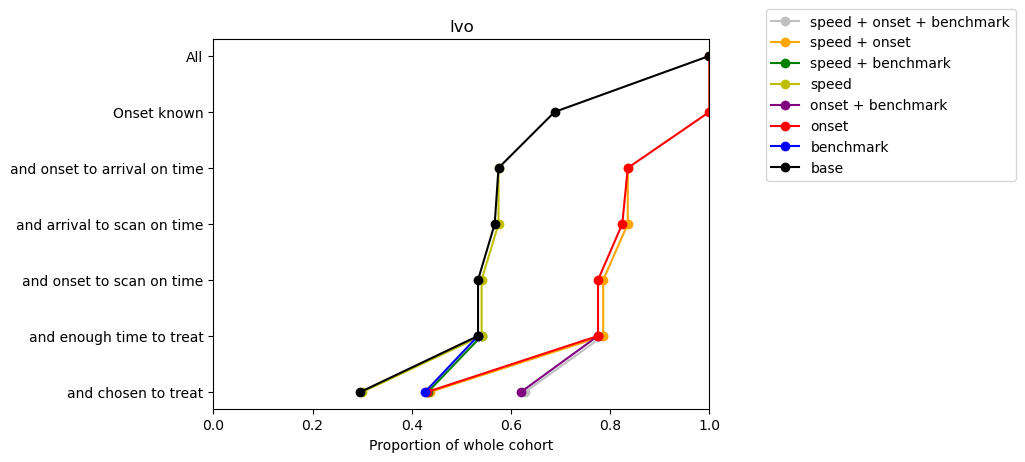

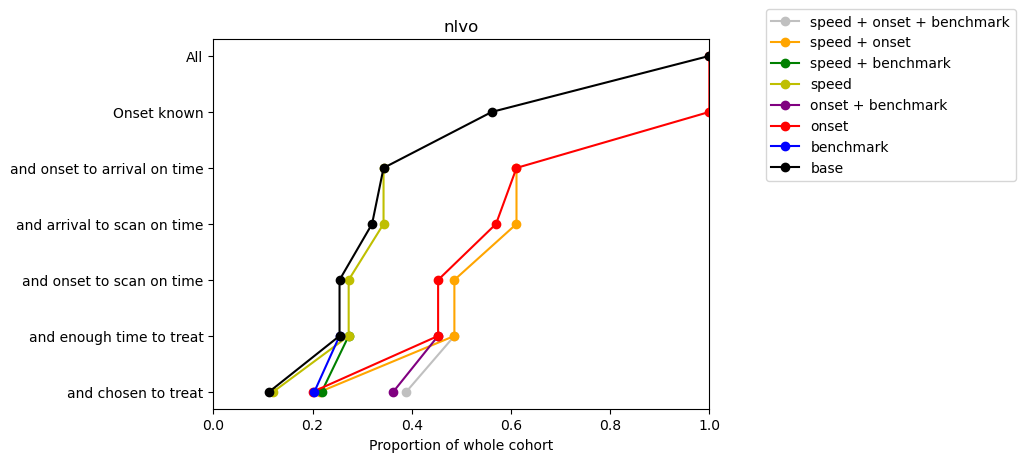

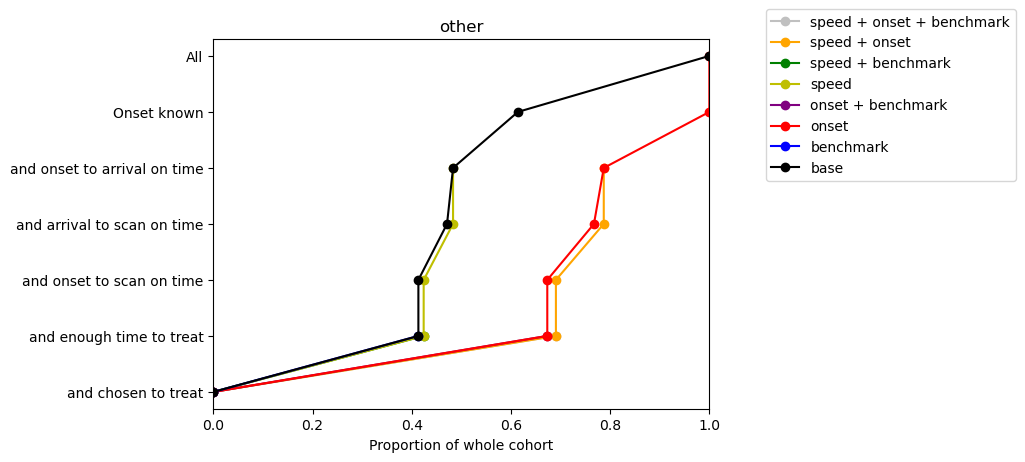

MT----------------------------------------------------------------------------------------------------


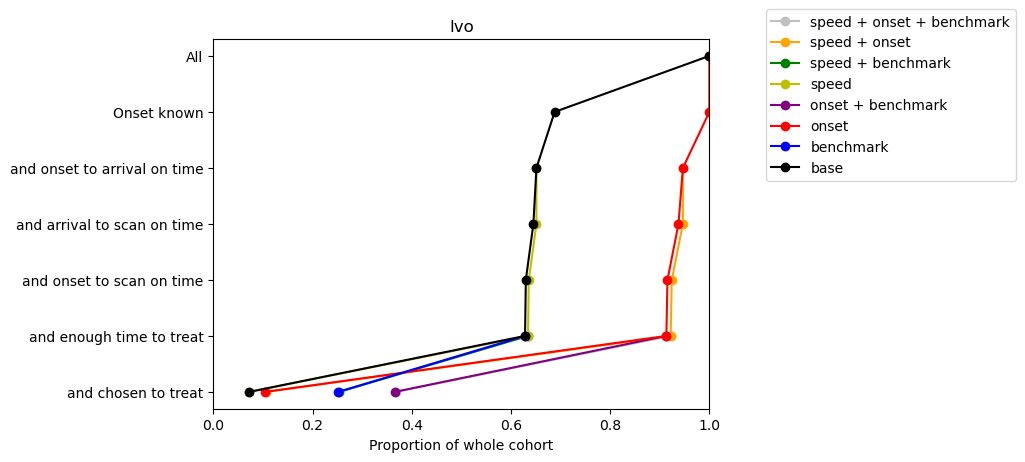

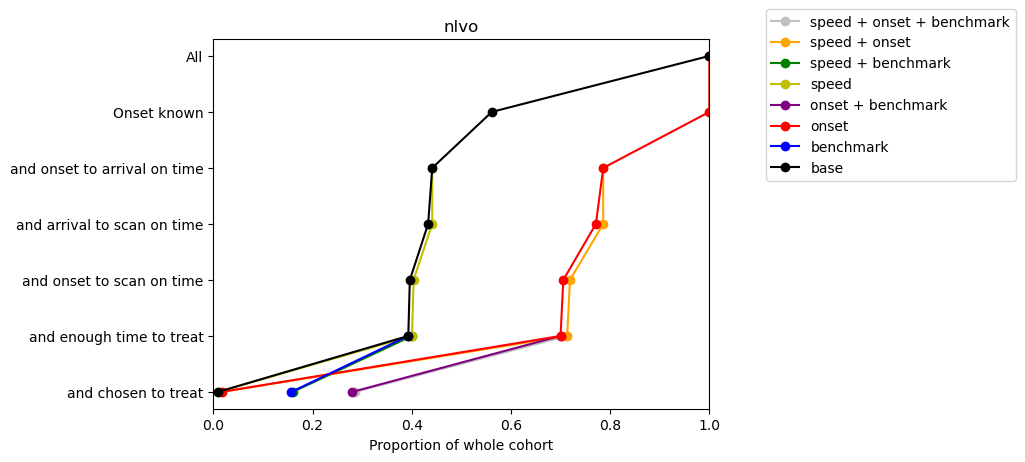

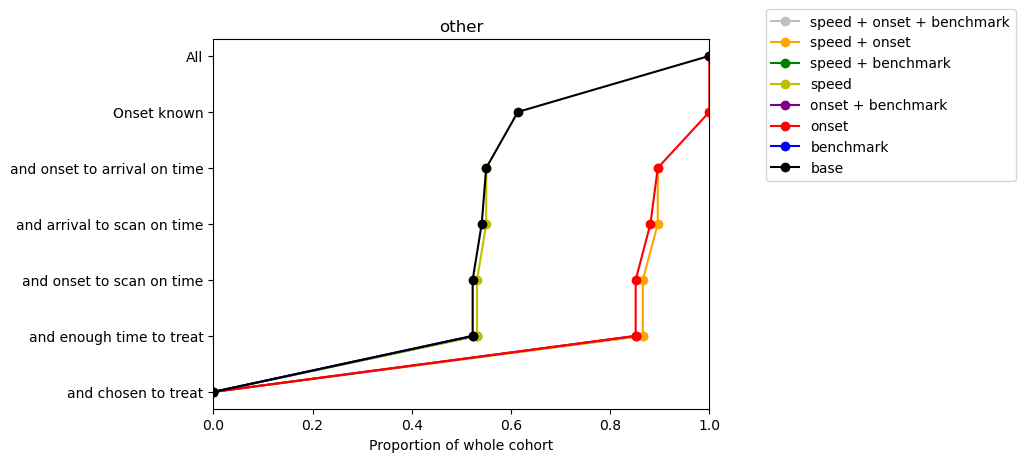

In [70]:
print('IVT' + '-'*100)
fig, ax = plt.subplots()
scatter_proportions(ax, stroke_type = 'lvo')
plt.show()


fig, ax = plt.subplots()
scatter_proportions(ax, stroke_type = 'nlvo')
plt.show()


fig, ax = plt.subplots()
scatter_proportions(ax, stroke_type = 'other')
plt.show()

print('MT' + '-'*100)
fig, ax = plt.subplots()
scatter_proportions(ax, stroke_type = 'lvo', treatment_type='mt')
plt.show()


fig, ax = plt.subplots()
scatter_proportions(ax, stroke_type = 'nlvo', treatment_type='mt')
plt.show()


fig, ax = plt.subplots()
scatter_proportions(ax, stroke_type = 'other', treatment_type='mt')
plt.show()

### Run the models:

In [71]:
np.random.seed(42)

# How many trials to run:
n_trials = 10

results_df, outcome_results_columns, trial_columns = set_up_results_dataframe()

for scenario_name in scenario_names:
    # Get data for one hospital.
    # Squeeze to convert DataFrame to Series.
    lvo_data = df_performance_scenarios[(
        (df_performance_scenarios['stroke_team'] == stroke_team) & 
        (df_performance_scenarios['stroke_type'] == 'lvo') &
        (df_performance_scenarios['scenario'] == scenario_name)
        )].copy().squeeze()
    nlvo_data = df_performance_scenarios[(
        (df_performance_scenarios['stroke_team'] == stroke_team) & 
        (df_performance_scenarios['stroke_type'] == 'nlvo') &
        (df_performance_scenarios['scenario'] == scenario_name)
        )].copy().squeeze()
    other_data = df_performance_scenarios[(
        (df_performance_scenarios['stroke_team'] == stroke_team) & 
        (df_performance_scenarios['stroke_type'] == 'other') &
        (df_performance_scenarios['scenario'] == scenario_name)
        )].copy().squeeze()

    # Set up trial results dataframe
    trial_df = pd.DataFrame(columns=trial_columns)
    # Set up the pathways with this data...
    pathway_object_dict = set_up_pathway_objects(stroke_team, lvo_data, nlvo_data, other_data)
    for trial in range(n_trials):
        # ... run the pathways...
        combo_trial_dict = run_trial_of_pathways(pathway_object_dict)
        # ... and run the clinical outcome model.
        results_by_stroke_type, patient_array_outcomes = (
            run_clinical_outcome_model(combo_trial_dict))

        result = gather_results_from_trial(trial_columns, combo_trial_dict, 
                                           results_by_stroke_type)
        trial_df.loc[trial] = result

    summary_trial_results = gather_summary_results_across_all_trials(outcome_results_columns, trial_df)
    # add scenario results to results dataframe
    results_df.loc[stroke_team + ' / ' + scenario_name] = summary_trial_results

scale 0.31108111129590754 ci95 6.097077744106745e-01
scale 0.18453238852097578 ci95 0.36167683548226504
scale 0.004255311494222995 ci95 0.008340257271676393
scale 0.04297268448635007 ci95 0.08422491391224923
scale 0.005955217894227955 ci95 0.011672012592775227
scale 0.0007978106317049668 ci95 0.001563680104624883
scale 0.008197281486481427 ci95 0.016066376484640557
scale 0.0010613908601267456 ci95 0.00208028785936841
scale 0.4848134046221801 ci95 9.502168122817167e-01
scale 0.5979802436059173 ci95 1.1720197409340862
scale 0.0028212330796867353 ci95 0.005529515228179016
scale 0.010871407951762741 ci95 0.02130756804669731
scale 0.006787895199671195 ci95 0.013304030122187838
scale 0.0005244195093455614 ci95 0.0010278433511074665
scale 0.0020721090522605842 ci95 0.004061259114470167
scale 0.0012064223801551415 ci95 0.002364544415247166
scale 0.5296942131716751 ci95 1.038181580635765e+00
scale 0.25547352366160114 ci95 0.5007189053802796
scale 0.002902707411433943 ci95 0.0056892019840680125


In [72]:
results_df.T

,Addenbrooke's Hospital / base,Addenbrooke's Hospital / benchmark,Addenbrooke's Hospital / onset,Addenbrooke's Hospital / onset + benchmark,Addenbrooke's Hospital / speed,Addenbrooke's Hospital / speed + benchmark,Addenbrooke's Hospital / speed + onset,Addenbrooke's Hospital / speed + onset + benchmark
Thrombolysis_rate_(%)_(median),14.054514,24.190801,23.168654,40.545145,16.524702,27.768313,28.790460,47.103918
Thrombolysis_rate_(%)_(low_5%),12.819421,21.354344,21.712095,37.725724,14.727428,26.124361,26.047700,41.516184
Thrombolysis_rate_(%)_(high_95%),15.570698,25.570698,26.005111,42.521295,18.339012,30.425894,30.127768,49.080068
Thrombolysis_rate_(%)_(mean),14.088586,23.696763,23.628620,40.136286,16.490630,27.938671,28.330494,46.320273
Thrombolysis_rate_(%)_(stdev),0.983725,1.533115,1.675040,1.864793,1.406641,1.561355,1.506808,2.753327
Thrombolysis_rate_(%)_(95ci),0.609708,0.950217,1.038182,1.155789,0.871829,0.967720,0.933912,1.706498
Thrombectomy_rate_(%)_(median),1.703578,16.950596,3.492334,27.512777,2.385009,18.313458,3.492334,29.897785
Thrombectomy_rate_(%)_(low_5%),1.516184,14.139693,2.086882,25.919932,1.252129,16.584327,2.257240,26.490630
Thrombectomy_rate_(%)_(high_95%),3.006814,19.250426,4.088586,29.659284,3.160136,20.434412,4.122658,30.851789
Thrombectomy_rate_(%)_(mean),2.010221,16.712095,3.339012,27.683135,2.282794,18.347530,3.304940,29.216354


### Work in progress - looking at results

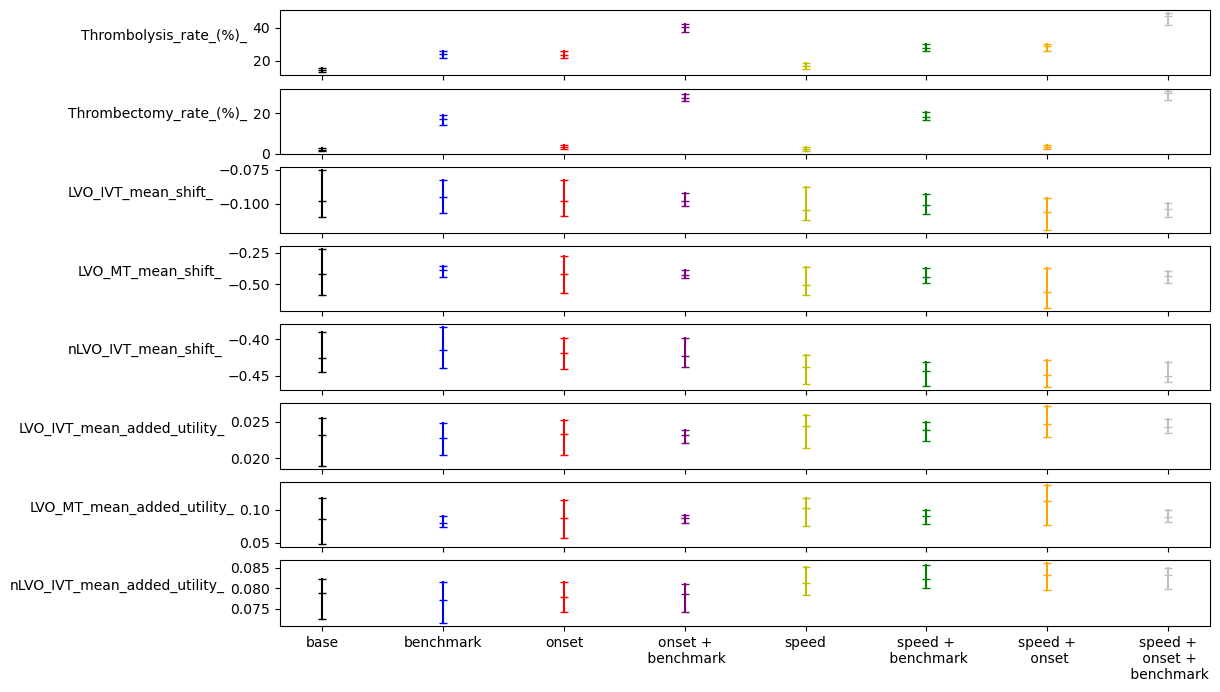

In [73]:
result_list = [
    'Thrombolysis_rate_(%)_',
    'Thrombectomy_rate_(%)_',
    'LVO_IVT_mean_shift_',
    'LVO_MT_mean_shift_',
    'nLVO_IVT_mean_shift_',
    'LVO_IVT_mean_added_utility_',
    'LVO_MT_mean_added_utility_',
    'nLVO_IVT_mean_added_utility_',
    ]

colour_dict = {
    'base': 'k',
    'benchmark': 'b',
    'onset': 'r',
    'onset + benchmark': 'purple',
    'speed': 'y',
    'speed + benchmark': 'green',
    'speed + onset': 'orange',
    'speed + onset + benchmark': 'silver'
    }

hospital_scenarios = list(results_df.index)

fig, axs = plt.subplots(len(hospital_scenarios), 1, figsize=(12, 8))
scenarios=[]
for s, hospital_scenario in enumerate(hospital_scenarios):

    df_here = results_df.loc[hospital_scenario]
    scenario = hospital_scenario.split('/ ')[-1]
    scenarios.append(scenario)
    for r, result_name in enumerate(result_list):
        ax = axs[r]
        yvals = [
            df_here[result_name + '(high_95%)'],
            df_here[result_name + '(median)'],
            df_here[result_name + '(low_5%)'],
            ]
        ax.plot([s]*3, yvals, label=scenario, color=colour_dict[scenario], marker='_')
        ax.set_ylabel(result_name, rotation=0, ha='right')
        
ylabels = result_list
xticklabels = ['+\n'.join(s.split('+')) for s in scenarios]
for ax in axs[:-1]:
    ax.set_xticks(np.arange(0, len(hospital_scenarios)))
    ax.set_xticklabels([])
axs[-1].set_xticks(np.arange(0, len(hospital_scenarios)))
axs[-1].set_xticklabels(xticklabels)

plt.show() 
    

## All hospitals, multiple trials and outcomes

In [74]:
stroke_teams = sorted(list(set([hospital.split(': ')[0] for hospital in hospital_performance.index])))

In [75]:
np.random.seed(42)

# How many trials to run:
n_trials = 10

results_df, outcome_results_columns, trial_columns = set_up_results_dataframe()

for hospital_name in stroke_teams:
    # Get data for one hospital.
    # Squeeze to convert DataFrame to Series.
    lvo_data = hospital_performance[(
        (hospital_performance.index == hospital_name) & 
        (hospital_performance['stroke_type'] == 'lvo')
        )].copy().squeeze()
    nlvo_data = hospital_performance[(
        (hospital_performance.index == hospital_name) & 
        (hospital_performance['stroke_type'] == 'nlvo')
        )].copy().squeeze()
    other_data = hospital_performance[(
        (hospital_performance.index == hospital_name) & 
        (hospital_performance['stroke_type'] == 'other')
        )].copy().squeeze()

    # Set up trial results dataframe
    trial_df = pd.DataFrame(columns=trial_columns)
    # Set up the pathways with this data...
    pathway_object_dict = set_up_pathway_objects(hospital_name, lvo_data, nlvo_data, other_data)
    for trial in range(n_trials):
        # ... run the pathways...
        combo_trial_dict = run_trial_of_pathways(pathway_object_dict)
        # ... and run the clinical outcome model.
        results_by_stroke_type, patient_array_outcomes = (
            run_clinical_outcome_model(combo_trial_dict))

        result = gather_results_from_trial(trial_columns, combo_trial_dict, 
                                           results_by_stroke_type)
        trial_df.loc[trial] = result

    summary_trial_results = gather_summary_results_across_all_trials(outcome_results_columns, trial_df)
    # add scenario results to results dataframe
    results_df.loc[hospital_name] = summary_trial_results

scale 0.31108111129590754 ci95 6.097077744106745e-01
scale 0.18453238852097578 ci95 0.36167683548226504
scale 0.004255311494222995 ci95 0.008340257271676393
scale 0.04297268448635007 ci95 0.08422491391224923
scale 0.005955217894227955 ci95 0.011672012592775227
scale 0.0007978106317049668 ci95 0.001563680104624883
scale 0.008197281486481427 ci95 0.016066376484640557
scale 0.0010613908601267456 ci95 0.00208028785936841
scale 0.319202364403054 ci95 6.256251380100153e-01
scale 0.18529613021147315 ci95 0.36317374168913164
scale 0.004584553601952048 ci95 0.008985559945019386
scale 0.04196978221229569 ci95 0.08225926157508934
scale 0.005686063996435723 ci95 0.0111444806468039
scale 0.0008532720349139946 ci95 0.0016723824574466327
scale 0.00804950427659242 ci95 0.01577673847552228
scale 0.001015507499211845 ci95 0.0019903581244855584
scale 0.3916756372541297 ci95 7.676701426398687e-01
scale 0.2019245776165525 ci95 0.39576489972190565
scale 0.005894307671172879 ci95 0.011552630749297008
scale 0

n.b. runtime warning about multiply error a * scale + loc is something to do with the above cell, not either of the pathway or outcome classes it's calling. Maybe that stats.norm.interval() line at the end?

In [76]:
results_df.head(10).T

,Addenbrooke's Hospital,Basildon University Hospital,Blackpool Victoria Hospital,Bradford and Airedale SU,Bronglais Hospital,Broomfield Hospital,Calderdale Royal Hospital,Charing Cross Hospital HASU,Chesterfield Royal,Colchester General Hospital
Thrombolysis_rate_(%)_(median),14.054514,12.734864,8.562368,7.192374,26.595745,10.407240,14.343598,13.039216,8.137255,9.741551
Thrombolysis_rate_(%)_(low_5%),12.819421,11.837161,6.860465,5.701906,19.521277,8.699095,11.118314,11.813725,6.558824,8.439364
Thrombolysis_rate_(%)_(high_95%),15.570698,14.425887,9.957717,8.318891,33.563830,11.685520,16.288493,15.245098,9.343137,11.968191
Thrombolysis_rate_(%)_(mean),14.088586,13.027140,8.435518,7.140381,26.702128,10.339367,13.922204,13.274510,8.039216,9.920477
Thrombolysis_rate_(%)_(stdev),0.983725,1.009407,1.238587,0.912694,5.246549,1.066793,1.907697,1.247151,1.004071,1.330177
Thrombolysis_rate_(%)_(95ci),0.609708,0.625625,0.767670,0.565683,3.251785,0.661193,1.182381,0.772978,0.622318,0.824437
Thrombectomy_rate_(%)_(median),1.703578,1.148225,0.845666,0.173310,0.000000,0.452489,0.567261,4.215686,0.000000,0.397614
Thrombectomy_rate_(%)_(low_5%),1.516184,0.281837,0.095137,0.000000,0.000000,0.226244,0.000000,2.941176,0.000000,0.198807
Thrombectomy_rate_(%)_(high_95%),3.006814,1.899791,1.828753,0.346620,0.000000,0.678733,0.826580,4.833333,0.500000,0.924453
Thrombectomy_rate_(%)_(mean),2.010221,1.064718,0.909091,0.155979,0.000000,0.475113,0.486224,4.039216,0.156863,0.457256


In [77]:
results_df.to_csv('full_outcome_pathway_results_refactored.csv')

### Work in progress - looking at results

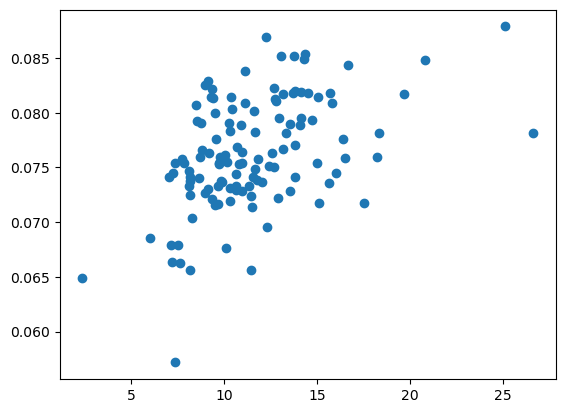

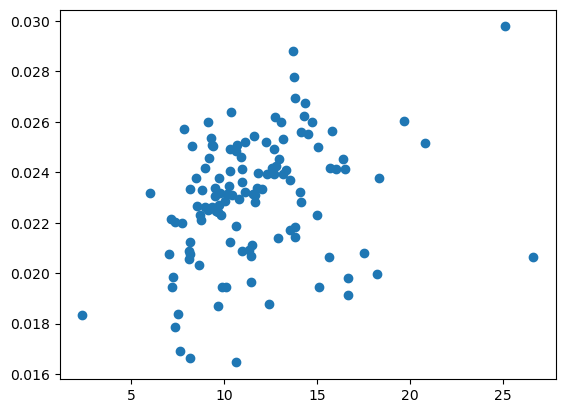

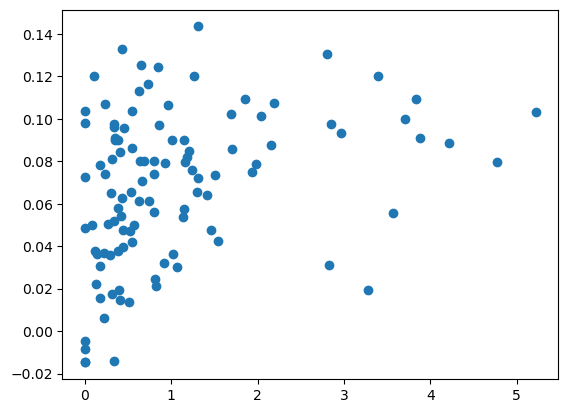

In [78]:
plt.scatter(
    results_df['Thrombolysis_rate_(%)_(median)'].values,
    results_df['nLVO_IVT_mean_added_utility_(median)'].values
)
plt.show()

plt.scatter(
    results_df['Thrombolysis_rate_(%)_(median)'].values,
    results_df['LVO_IVT_mean_added_utility_(median)'].values
)
plt.show()

plt.scatter(
    results_df['Thrombectomy_rate_(%)_(median)'].values,
    results_df['LVO_MT_mean_added_utility_(median)'].values
)

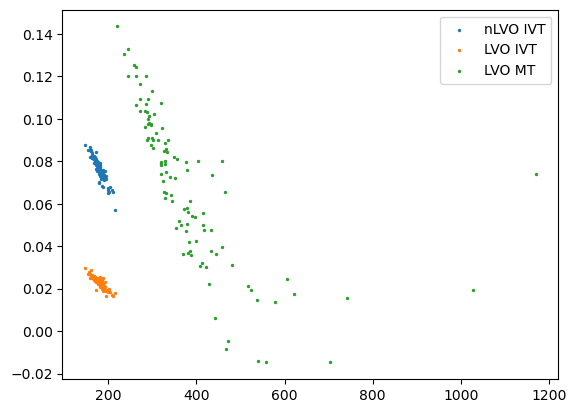

In [79]:
plt.scatter(
    results_df['onset_to_needle_mins(mean)'].values,
    results_df['nLVO_IVT_mean_added_utility_(median)'].values,
    label='nLVO IVT', s=2
)
# plt.show()

plt.scatter(
    results_df['onset_to_needle_mins(mean)'].values,
    results_df['LVO_IVT_mean_added_utility_(median)'].values,
    label='LVO IVT', s=2
)
# plt.show()

plt.scatter(
    results_df['onset_to_puncture_mins(mean)'].values,
    results_df['LVO_MT_mean_added_utility_(median)'].values,
    label='LVO MT', s=2
)

plt.legend()

^ these things shouldn't be directly linked - change in utility only uses the treated patients, so treatment rate shouldn't matter.